## Setup
First we will import the necessary libraries, including utilities in the Satellite_ComputerVision repo, instantiate our dask client, and connect to blob storage

In [1]:
!pip install -q stac-vrt

In [ ]:
!git clone https://github.com/mjevans26/Satellite_ComputerVision.git

In [ ]:
import Satellite_ComputerVision.utils.pc_tools as pc_tools
import Satellite_ComputerVision.utils.model_tools as model_tools
from dask.distributed import Client
from dask_gateway import GatewayCluster
import numpy as np

In [3]:
cluster = GatewayCluster(shutdown_on_close = True)  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=16, maximum=24)

print(cluster.dashboard_link) # We can use this link to monitor our jobs and worker nodes

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.3a7ae3ea26bb49f5a2ac0bcd362ce0fb/status


In [9]:
# Connect to the planetary computer STAC catalog
api = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [8]:
sas_token = ''
model_blob_url = f'https://aiprojects.blob.core.windows.net/solar/models/solar_Jun21/unet256[1].h5?{sas_token}'
weights_blob_url = f'https://aiprojects.blob.core.windows.net/solar/models/solar_Jun21/best_weights_01Jul21[1].hdf5?{sas_token}'

In [52]:
def get_weighted_bce(y_true, y_pred):
    model_tools.weighted_bce(y_true, y_pred)

m = pc_tools.get_blob_model(model_blob_url = model_blob_url, weights_blob_url = weights_blob_url, custom_objects = {'get_weighted_bce':get_weighted_bce})
m.summary()

In [12]:
import geopandas as gpd
counties = gpd.read_file('/home/jovyan/data/landcover_dates.geojson') 

In [13]:
counties[counties['State']=='MD'].head()

,County,State,T1,T2,co_fips,fips,geometry
4,Allegany,MD,2013,2018,alle_24001,24001,"POLYGON ((-78.72077 39.72303, -78.70645 39.722..."
5,Anne Arundel,MD,2013,2018,anne_24003,24003,"MULTIPOLYGON (((-76.52859 39.21749, -76.52965 ..."
6,Baltimore,MD,2013,2018,balt_24005,24005,"MULTIPOLYGON (((-76.34543 39.25375, -76.34760 ..."
7,Baltimore City,MD,2013,2018,balt_24510,24510,"POLYGON ((-76.53496 39.21228, -76.53588 39.211..."
8,Calvert,MD,2013,2018,calv_24009,24009,"POLYGON ((-76.52959 38.71402, -76.52924 38.713..."


In [ ]:
import stac_vrt
import planetary_computer

from scv.utils.model_tools import weighted_bce, weighted_crossentropy, get_unet_model
import scv.utils.pc_tools

from dask.distributed import Client
from dask_gateway import GatewayCluster
import stackstac
import pystac_client

import rasterio as rio
from rasterio.merge import merge
import geopandas as gpd
import numpy as np
import xarray as xr

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt
from matplotlib import colors

from azure.storage.blob import ContainerClient

import re

## Single County Testing
Lets test our predictions tools locally on a single county

In [33]:
county = counties[counties['co_fips']=='prin_24033'] # PG county MD
cofips = county['co_fips'].iloc[0]
geom = county.geometry

In [34]:

search = api.search(
    intersects=geom.iloc[0],
    datetime="2022-05-01/2022-09-30",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 10}} # filter images to those with < 10% cloudy pixels
)


In [35]:
signed = pc_tools.recursive_api_try(search)

22 s2 assets


In [36]:
crss = [asset['properties']['proj:epsg'] for asset in signed]

In [37]:
data = (
    stackstac.stack(
        signed,
        assets=["B02", "B03", "B04", "B08", "B11", "B12"],  # red, green, blue, NIR, SWIR1, SWIR2
        epsg = crss[0],
        chunksize=4096,
        resolution=10,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords({'band':['B2', 'B3', 'B4', 'B8', 'B11', 'B12']})  # use GEE names that model expects
)

data

,Array,Chunk
Bytes,226.58 GiB,128.00 MiB
Shape,"(22, 6, 20982, 10980)","(1, 1, 4096, 4096)"
Count,5 Graph Layers,2376 Chunks
Type,float64,numpy.ndarray


In [38]:
median = data.median(dim="time").rio.write_crs(data.attrs['crs']).rio.clip([geom.iloc[0]], crs = 4326)
median

,Array,Chunk
Bytes,1.09 GiB,2.00 MiB
Shape,"(6, 6648, 3664)","(1, 512, 512)"
Count,12 Graph Layers,672 Chunks
Type,float64,numpy.ndarray


In [39]:
norm = pc_tools.normalize_dataArray(median, 'band')
norm

,Array,Chunk
Bytes,1.09 GiB,2.00 MiB
Shape,"(6, 6648, 3664)","(1, 512, 512)"
Count,24 Graph Layers,672 Chunks
Type,float64,numpy.ndarray


In [40]:
# The Unet model doesn't like partial chunks, so we chop off the
# last 1-31 pixels.


trimmed = pc_tools.trim_dataArray(norm, 256).chunk({'x':256, 'y':256, 'band':6})
trimmed

<xarray.DataArray 'stackstac-cef34ee772f388bd5e71d79155536c79' (band: 6,
                                                                y: 6400, x: 3584)>
dask.array<rechunk-merge, shape=(6, 6400, 3584), dtype=float64, chunksize=(6, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * band                                     (band) <U3 'B2' 'B3' ... 'B12'
  * x                                        (x) float64 3.186e+05 ... 3.544e+05
  * y                                        (y) float64 4.333e+06 ... 4.269e+06
    s2:product_type                          <U7 'S2MSI2A'
    sat:orbit_state                          <U10 'descending'
    s2:processing_baseline                   <U5 '04.00'
    ...                                       ...
    title                                    (band) <U26 dask.array<chunksize=(6,), meta=np.ndarray>
    common_name                              (band) <U6 dask.array<chunksize=(6,), meta=np.ndarray>
    center_wavelength                        (band) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    full_width_half_max                      (band) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    epsg                                     int64 32618
    spatial_ref                              int64 0

In [41]:
# predictions_array is a dask.array - spatially naive
meta = np.array([[]], dtype="float32")

predictions_array = trimmed.data.map_overlap(
    lambda x: pc_tools.predict_chunk(x, model_blob_url = model_blob_url, weights_blob_url = weights_blob_url, custom_objects = {'get_weighted_bce':get_weighted_bce})
    depth = (0, 64, 64),
    boundary = 0,
    meta=meta,
    drop_axis=0
)

test = predictions_array.compute()

In [30]:
# to restore spatial reference, cast back to Xarray
predictions = xr.DataArray(
    test,
    coords = {'y':trimmed.coords['y'], 'x':trimmed.coords['x']},
    dims = ('y', 'x')
).rio.set_crs(trimmed.rio.crs)

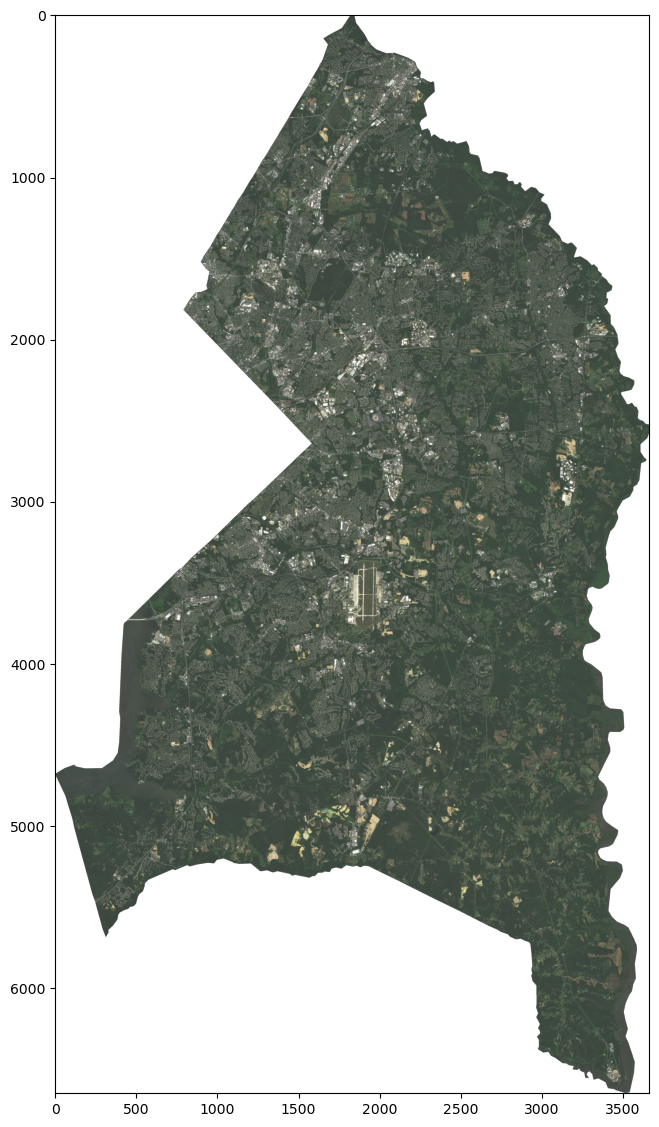

In [31]:

# imageb = medianb.values
# imagea = mediana.values
# hwcb = np.moveaxis(imageb[0:3,:,:], 0, -1)
tile = ms.true_color(*[median[i,0:median.shape[1],0:median.shape[2]] for i in [2,1,0]])
# chipb = ms.true_color(r = medianb[2,0:test.shape[0],test.shape[1]], g = medianb[1,0:256,0:512], b = medianb[0,0:256,0:512])
# chipa = ms.true_color(r = mediana['B4'], g = mediana['B3'], b = mediana['B2'])
fig, ax = plt.subplots(figsize=(14, 14))

ax.imshow(tile)

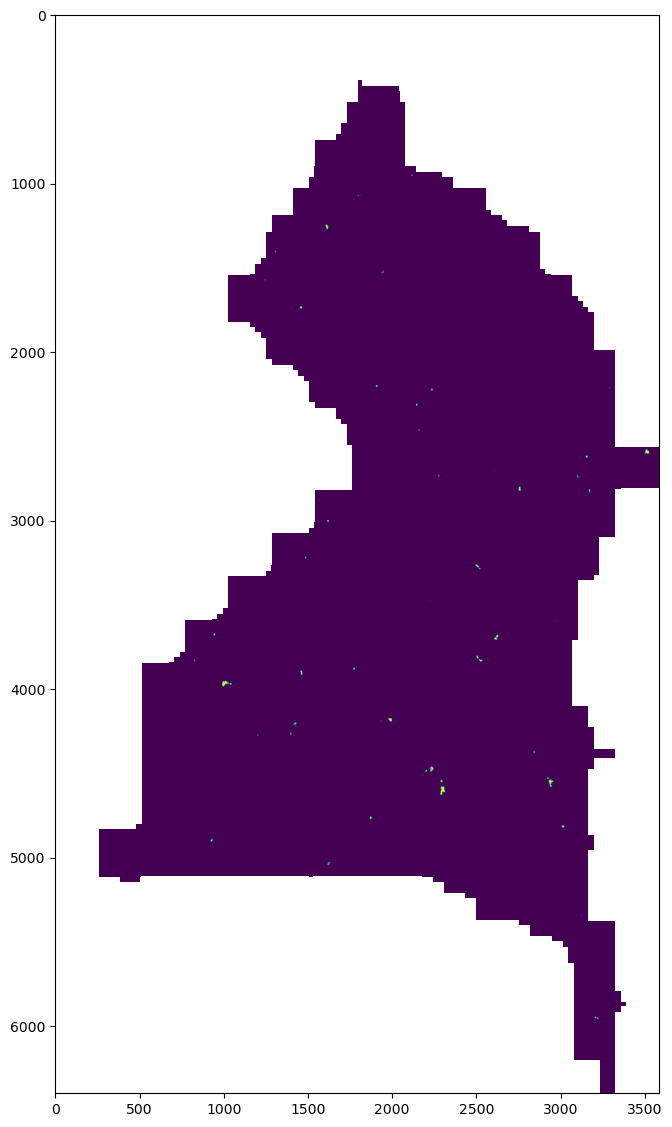

In [32]:

fig, ax = plt.subplots(figsize=(14, 14))
#3d4551#f39268#d54309#00a398#1B1716
ax.imshow(test)

In [46]:
predictions.rio.to_raster('./tmp.tif')
container_client = ContainerClient.from_container_url(
    container_url = f'https://aiprojects.blob.core.windows.net/solar?{sas_token}'
)
output_client = container_client.get_blob_client(f"output/{cofips}/2022/solar_Jun21.tif")
with open('./tmp.tif', 'rb') as f:
    output_client.upload_blob(f, overwrite = True)   

## Scale w/Dask
Define a function that can be applied across a geodataframe and parallelize predictions by county with Dask

In [ ]:
def fxn(row, sas_token):
    cofips = row['co_fips']
    print(cofips)
    container_client = ContainerClient.from_container_url(
        container_url = f'https://aiprojects.blob.core.windows.net/solar?{sas_token}'
    )
    blob_generator = container_client.list_blobs(name_starts_with = f'output/{cofips}/2022/')
    urls = [f'https://cbpbigshare.blob.core.windows.net/{blob.container}/{blob.name}' for blob in blob_generator]
    if len(urls) > 0:
        print('already done, skipping')
        pass
    else:
        geom = row.geometry
        search = api.search(
            intersects=geom,
            datetime="2022-05-01/2022-09-30",
            collections=["sentinel-2-l2a"],
            limit=500,  # fetch items in batches of 500
            query={"eo:cloud_cover": {"lt": 10}},
        )
        
        signed = pc_tools.recursive_api_try(search)

        crss = [asset['properties']['proj:epsg'] for asset in signed]
        data = (
            stackstac.stack(
                signed,
                assets=["B02", "B03", "B04", "B08", "B11", "B12"],  # red, green, blue, NIR, SWIR1, SWIR2
                epsg = crss[0],
                chunksize=4096,
                resolution=10,
            )
            .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
            .assign_coords({'band':['B2', 'B3', 'B4', 'B8', 'B11', 'B12']})  # use GEE names that model expects
        )
        median = data.median(dim="time").rio.write_crs(data.attrs['crs']).rio.clip([geom], crs = 4326)
        norm = pc_tools.normalize_dataArray(median, 'band')
        trimmed = pc_tools.trim_dataArray(norm, 256).chunk({'x':256, 'y':256, 'band':6})
        meta = np.array([[]], dtype="float32")
        predictions_array = trimmed.data.map_overlap(
            lambda x: pc_tools.predict_chunk(x, model_blob_url = model_blob_url, weights_blob_url = weights_blob_url, custom_objects = {'get_weighted_bce':get_weighted_bce}),
            depth = (0, 64, 64),
            boundary = 0,
            meta=meta,
            drop_axis=0
        )
        print('running predictions')
        test = predictions_array.compute()
        predictions = xr.DataArray(
            test,
            coords = {'y':trimmed.coords['y'], 'x':trimmed.coords['x']},
            dims = ('y', 'x')
        ).rio.set_crs(trimmed.rio.crs)
        print('saving to temp file')
        predictions.rio.to_raster('./tmp.tif')

        output_client = container_client.get_blob_client(f"output/{cofips}/2022/solar_Jun21.tif")
        print('writing to blob')
        with open('./tmp.tif', 'rb') as f:
            output_client.upload_blob(f, overwrite = True) 

In [ ]:
states = counties.dissolve(by = 'State', as_index = False)

md_counties = counties[counties['State'] == 'MD']

md_counties.head()

In [ ]:
md_counties.apply(fxn, axis = 1, **{'sas_token':sas_token})

### Consolidate counties per state

In [20]:
container_client = ContainerClient.from_container_url(
        container_url = f'https://aiprojects.blob.core.windows.net/solar?{sas_token}'
    )
blob_generator = container_client.list_blobs(name_starts_with = 'output/')
urls = [f'https://aiprojects.blob.core.windows.net/{blob.container}/{blob.name}' for blob in blob_generator]
md_urls = [url for url in urls if bool(re.search('..._42...', url))]

md_urls

['https://aiprojects.blob.core.windows.net/solar/output/adam_42001/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/bedf_42009/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/berk_42011/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/blai_42013/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/brad_42015/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/camb_42021/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/came_42023/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/carb_42025/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/cent_42027/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/ches_42029/2022/solar_Jun21.tif',
 'https://aiprojects.blob.core.windows.net/solar/output/clea_42033/2022/solar_Jun21.tif',
 'https://

In [24]:

with rio.open(pa_urls[0]) as src:
    out_meta = src.meta.copy()
tifs_to_merge = [rio.open(url) for url in pa_urls]


In [25]:
mosaic, out_trans = merge(tifs_to_merge)

In [26]:
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans
                 }
                )
with rio.open('tmp.tif', "w", **out_meta) as dst:
   dst.write(mosaic)